# Fourieriser
By Mark Schlutow

In [1513]:
import numpy as np
import matplotlib.pyplot as plt
# import pyhdf.SD as SD
from archive import converter
import scipy.fftpack as scfft

%matplotlib inline

## Initalisation stuff

In [1575]:
modelstr = 'psinc'
casestr  = 'C500e-5'
# casestr  = 'C000e-5'

test_case = 'Internal-Wave-Long-Wave'

showmode = 1
separate_signs = 1
filledcontours = 1
fixed_contours = 0
fixed_contour_step = 0
no_of_contours = 20
show_increments = 0
symmetry = 0        # in {0,1}
symmetrytest = 0
showdummycells = 0
plotverticaltrace = 0 
vtraceat = 23
cmpr_slns = 1  # currently to be in {0,1}, extendable by more foldernames 

dtheta = 0.5e-3/300
contour_values = [-5*dtheta, -4*dtheta, -3*dtheta, -2*dtheta, -dtheta, 0.0, dtheta, 2*dtheta, 3*dtheta, 4*dtheta, 5*dtheta]
title_true = 1

kmin = 1
kmax = 600
dk   = 1
ntime = (kmax-kmin+1)//dk

if test_case == 'Internal-Wave-Long-Wave':
    slic = 'xy' # options:  'xy' 'zx' 'yz'
    #slic = 'yz' # options:  'xy' 'zx' 'yz'
    #slic = 'zx' # options:  'xy' 'zx' 'yz'
    
    flowplane = 'xy' # options:  'xy' 'yz' 'zx'
    #flowplane = 'yz' # options:  'xy' 'yz' 'zx'
    #flowplane = 'zx' # options:  'xy' 'yz' 'zx'
    
    if flowplane == 'xy':
        scalefactor = 20.0
        ncx = 301
        ncy =  10
        ncz =   1
        L   = 300.0 * scalefactor  #
        x0  = 0.0*L
        H   = 10.0  #
        B   = 10.0
        aspect = [L/H/3, 1, 1]
        velosc = 100  # velocity unit of RKLM code
        Tempsc = 1.0
        x0  = 0.5*L
        y0  = 0.0*H
        z0  = 0.5*B
        
nnx = ncx+1
dumsx = 2
if ncy == 1:
    nny = 1
    dumsy = 0
else:
    nny = ncy+1
    dumsy = 2

if ncz == 1:
    nnz = 1
    dumsz = 0
else:
    nnz = ncz+1
    dumsz = 2


modelfigstr = '  ('+modelstr+')'

rhoY_diff = 0
rhoZ_diff = 0
transp    = 0

#folderstring = []
folderstring = 'SkamarockKlempIntermediate/'+modelstr+'/'+casestr+'/' # Coriolis = casestr
folderstring = 'low_Mach_gravity_psinc/' # Coriolis = casestr
#folderstrings.append('SkamarockKlempIntermediate/'+modelstr+'/'+'C000e-5') # Reference Coriolis = 0

# reference quantities
denssc = 1.16  # [kg/m^^]
Tempsc = 300.0 # [K]
pressc = 1.0e5 # [kg/m/s^2] = [Pa]
velosc = 100.0 # [m/s]

# Potential temperature deviation
varstr = 'dY'  
folderstr = 'dY' 
titlestr = 'dY' 
ndummy = 2 
arraysize = [ncx, ncy, ncz] 
filledcontours = 1 
varsc = Tempsc

## Simple converter and plotter for the C-code outputs

/home/ray/git-projects/RKLM_Reference/visualiser_debugger/plotting_tools.py:160: UserWarning: No contour levels were found within the data range.
  im = cax.contour(arr,colors='k')


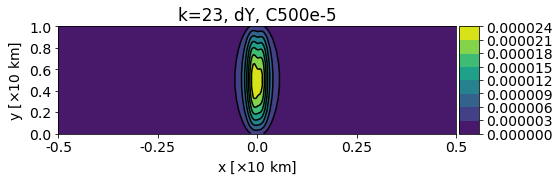

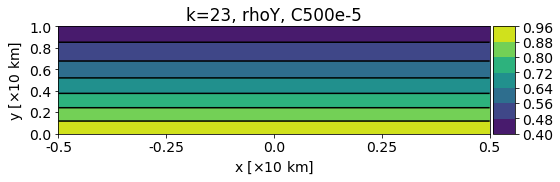

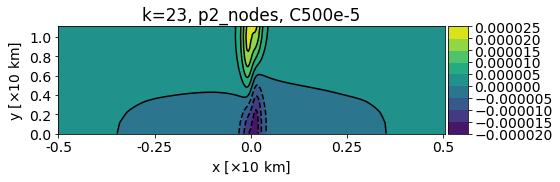

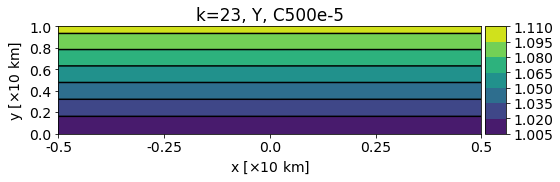

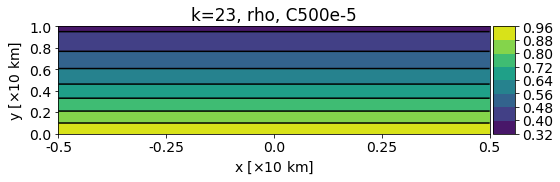

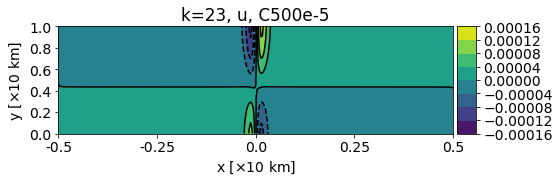

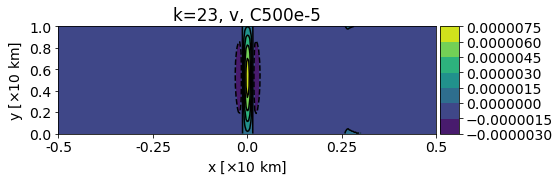

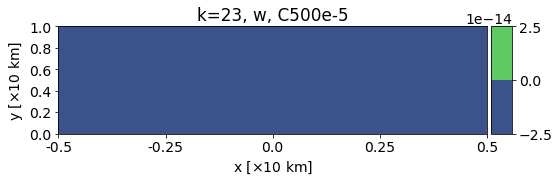

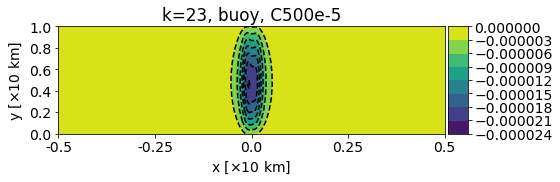

In [1673]:
dbg_data = np.zeros([ncx,ncy,ntime])

directory = ['dY','rhoY','p2_nodes','Y','rho','u','v','w','buoy']
filename = ['dY','rhoY','p2_n','Y','rho','u','v','w','buoy']

k = 23

conv = converter.convert(folderstring,'','%.3d' %k,'')
conv.convert_files(directory,filename,debug=False)
SD = conv.get_converted_files(directory,filename)

for qty in directory:
    conv = converter.convert(folderstring,'','%.3d' %k,'')
    SD = conv.get_converted_files(directory,filename)
    arr = getattr(SD, qty)[...,-1]
    arr = arr[2:-2,2:-2]

    ll_rklm = [arr.T, 'k=%i, %s, %s' %(k, qty, casestr)]

    pl_lst = [ll_rklm]

    pl = pt.plotter(pl_lst,ncols=1,figsize=(8,3),sharey=False)
    x_axs = [-0.5,-0.25,0.0,0.25,0.5]
    y_axs = [-0.5,-0.25,0.0,0.25,0.5]
    y_axs = np.array([0.0,2.0,4.0,6.0,8.0,10.0]) / 10.0
    x_loc = np.linspace(0,Nx-1,5)
    y_loc = np.linspace(0,Ny-1,6)
    x_label = r'x [$\times 10$ km]'
    y_label = r'y [$\times 10$ km]'

    pl.set_axes(y_locs=y_loc,y_axs=y_axs)
    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
    _ = pl.plot(method='contour', lvls=None)

## Mark's Fourier plot

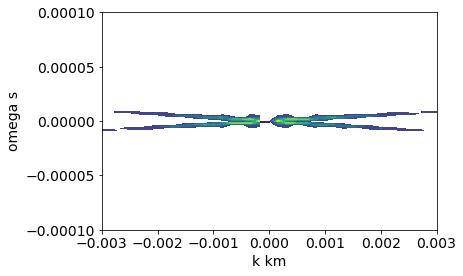

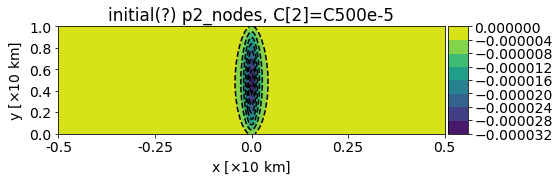

In [1580]:
if slic == 'xy':
    nslice = np.floor((ncz+1)/2)
elif slic == 'yz':
    nslice = np.floor((ncx+1)/2)
else:
    nslice = np.floor((ncy+1)/2)

# save all time steps in one variable
data = np.zeros([ncx,ncy,ntime])
dbg_data = np.zeros([ncx+4,ncy+4,ntime])
dbg_data = np.zeros([ncx+1,ncy+1,ntime])
dbg_data = np.zeros([ncx,ncy,ntime])

load_icc = np.zeros([ncx+4,ncy+4,ntime])
load_icn = np.zeros([ncx+5,ncy+5,ntime])
#scrsz = get(0,'ScreenSize')
# fig, ax = plt.subplots(ntime)# figure('Position',[1 2*scrsz(4)/3 (1+2*cmpr_slns)*scrsz(4)/2 1*scrsz(4)/3])

ik = 0

directory = ['dY','rhoY','p2_nodes','Y','rho','u','v','buoy']
filename = ['dY','rhoY','p2_n','Y','rho','u','v','buoy']

# directory = ['dY','rhs_nodes']
# filename = ['dY','rhs_nodes']
for k in range(kmin,kmax+1,dk):
    conv = converter.convert(folderstring,'','%.3d' %k,'')
    conv.convert_files(directory,filename,debug=False)
    SD = conv.get_converted_files(directory,filename)
#     print(SD.dY[:].shape)
    v = SD.dY[:]
    dbg = SD.buoy[:]
    
    idxx = 2
    if k == 6:
        for name in directory:
            arr = getattr(SD,name)[:][...,2]
#             print(arr.shape)
            if k > 0:
                np.save('ic_%s_%i.npy' %(name,k), arr)
            else:
                np.save('ic_%s.npy' %(name), arr)
    
    kstr = str(k)
    if k < 10:
        filestr = folderstring+'/'+folderstr+'/'+varstr+'_%.3d'+kstr+'.hdf'

#     hdf = SD.SD(filestr)
#     v = hdf.select('Data-Set-2')
#     v.get(start=(0,0,0), stride=(1,1,1))
#     #v = hdfread(filestr, '/Data-Set-2', 'Index', {[1  1  1],[1  1  1],[arraysize(1)+2*ndummy  arraysize(2)+2*ndummy  arraysize(3)+2*ndummy]})
    
    if rhoY_diff:
        v = v - rhoY_diff

    [nx, ny, nz] = v[:,:,:].shape
    nx = nx - 2*ndummy
    ny = ny - 2*ndummy
    nz = nz - 2*ndummy
    nnx, nny, nnz = nx+1, ny+1, nz+1
    
    dx = L/nx
    dy = H/ny
    dz = B/nz
    v = v[2:nx+2:1, 2:ny+2:1, 2:nz+2:1]
    dbg = dbg[slice(2,-2),slice(2,-2),slice(2,-2)]
#     dbg = dbg[2:nx+2:1, 2:ny+2:1, 2:nz+2:1]

    # for now let's take it slic by slic
    sz = v[:,:,:].shape
    if slic == 'xy':
        velo = v[:,:,int(nslice)-1]
        dbg_field = dbg[:,:,int(nslice)-1]
        hlabl = 'x'
        hlen  = L
        hdel  = dx
        hcoord0 = x0
        vlabl = 'y'
        vlen  = H
        vdel  = dy
        vcoord0 = y0

        data[:,:,ik] = velo
        dbg_data[:,:,ik] = dbg_field
                    
        [nxx, nzz] = velo.shape
        
        dth = 8.3333e-04
        
#         if slic == 'xy':
        dxx = L/nxx
        dzz = H/nzz
        xx = np.linspace(0.5*hdel-hcoord0,-0.5*hdel+nxx*hdel-hcoord0,nxx)
        zz = np.linspace(0.5*vdel-vcoord0,-0.5*vdel+nzz*vdel-vcoord0,nzz)

#     ax[ik].contourf(xx,zz,np.transpose(velo))
#     ax[ik].set_title(titlestr+kstr)

    # Create xlabel
#     ax[ik].set_xlabel(hlabl)
        
    # Create ylabel
#     ax[ik].set_ylabel(vlabl)
    
    ik = ik+1

#For isothermal atmosphere, reference brunt frequency
cp  = 1004 # J / kg / K
bvf = 9.81**2 / cp / Tempsc
bvf = np.sqrt( bvf )

bvf = 1 / 100

# fouriertrafo 2D
iz = 5 # 5.5km

sel = data[:,iz,:]-np.mean(data[:,iz,:])
F = scfft.fft2(sel)

F = F / np.max(abs(F))

k     = scfft.fftfreq(nx,dxx)
#omega = fftfreq(ntime,dk)
omega = scfft.fftfreq(ntime,10/bvf)

propfac = 0.031

ot1 = +propfac * k
ot2 = -propfac * k

fig2, ax2 = plt.subplots()
ax2.set_xlim( [ -0.003, 0.003 ] )
ax2.set_ylim( [ -0.0001, 0.0001 ] )
ax2.contourf( k, omega, np.transpose( np.abs( F ) ) )
# ax2.plot( k, ot1, k, ot2 )
plt.xlabel('k km')
plt.ylabel('omega s')
plt.show()

ll_rklm = [dbg_data[...,2].T, 'initial(?) p2_nodes, C[2]=%s' %casestr]
pl_lst = [ll_rklm]

pl = pt.plotter(pl_lst,ncols=1,figsize=(8,3),sharey=False)
x_axs = [-0.5,-0.25,0.0,0.25,0.5]
y_axs = [-0.5,-0.25,0.0,0.25,0.5]
y_axs = np.array([0.0,2.0,4.0,6.0,8.0,10.0]) / 10.0
x_loc = np.linspace(0,Nx-1,5)
y_loc = np.linspace(0,Ny-1,6)
x_label = r'x [$\times 10$ km]'
y_label = r'y [$\times 10$ km]'

pl.set_axes(y_locs=y_loc,y_axs=y_axs)
pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
_ = pl.plot(method='contour', lvls=None)

# Repeat analysis for Python output

In [447]:
from importlib import reload
import plotting_tools as pt
import utils
import dsi
utils = reload(utils)
pt = reload(pt)
dsi = reload(dsi)

import pickle
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../RKLM_Python/')

import matplotlib.pyplot as plt

## Initialisation stuff

In [1411]:
Nx, Ny = 301, 10
N = 1

def load(Nx,Ny,et):
    base_fn = 'output_internal_long_wave'
    pydir = '../%s/' %base_fn

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et)
    tags = tc.get_tag_dict()
    
    return tc, tags

i2 = (slice(2,-2),slice(2,-2))

## Fourier plotter

../output_internal_long_wave/output_internal_long_wave_ensemble=1_301_10_600.0_long_psinc_vcor_nocor.dat
0.0004991652754590984 -0.0004991652754590984


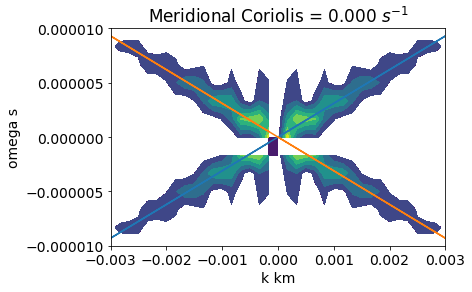

/home/ray/git-projects/RKLM_Reference/visualiser_debugger/plotting_tools.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.arr_lst = np.array(arr_lst)


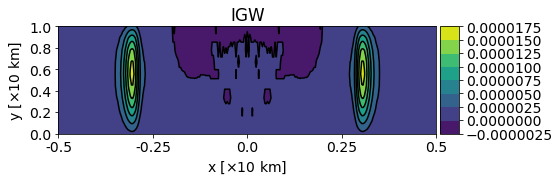

In [1672]:
l_typ = 'WINDOW_STEP'
diff = False

attr_labels = pt.labels()

def get_ens(tc, times, sfx , diff, attribute, tag='after_full_step', load_ic=True):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=False, load_ic=load_ic)[:]
    
    label = sfx + '_' + attribute
    return label, ens.T

typ = 'nonhydro_vcor'
typ = 'psinc_vcor_nocor'
# typ = 'hydro'
# typ = 'psinc'

et = 30.0
sfx1 = 'standard_%s' %typ

et = 600.0
sfx1 = 'long_%s' %typ

# et = 4800.0
# sfx1 = 'planetary_%s' %typ

tc, tags = load(Nx,Ny,et)
times = [et]
times = np.arange(1,600.0)

# load pickled instances of data used in simulation
fn_pickle = tc.get_filename(N,sfx1,format='dat')
path_pickle = tc.get_path(fn_pickle)
print(path_pickle)

file = open(path_pickle,'rb')
ud = pickle.load(file)
mpv = pickle.load(file)
dap = pickle.load(file)
elem = pickle.load(file)
file.close()

S0 = (ud.stratification(elem.y)).reshape(-1,1)
S0 = S0[...,np.newaxis]

attribute = 'rho'
_, a1 = get_ens(tc, times, sfx1, diff, attribute)
attribute = 'rhoY'
_, a2 = get_ens(tc, times, sfx1, diff, attribute)

if a1.ndim == 3+1:
    a1 = a1[3,...]
    a2 = a2[3,...]

la = 'IGW'
aa = a2 / a1
aa -= S0 #* ud.T_ref
aa = aa[i2] #* ud.T_ref
# aa *= ud.T_ref

aa = np.swapaxes(aa[...,1:],0,1)
nxx, nzz, ntt = aa.shape
dxx = L/nxx

# fouriertrafo 2D
ntime = len(times)
iz = 5 # 5.5km

sel = aa[:,iz,:]-np.mean(aa[:,iz,:])
Fpy = scfft.fft2(sel)
Fpy = Fpy / np.max(abs(F))

k     = scfft.fftfreq(nxx,dxx) 
omega = scfft.fftfreq(ntime,10/bvf)

print(omega.max(), omega.min())
fig2, ax2 = plt.subplots()
ax2.set_xlim( [ -0.003, 0.003 ] )
ax2.set_ylim( [ -0.00001, 0.00001 ] )
ax2.contourf( k, omega, np.transpose( np.abs( Fpy ) ) )
ax2.plot( k, ot1, k, ot2 )
plt.xlabel('k km')
plt.ylabel('omega s')
cor = -ud.coriolis_strength[2] / ud.t_ref
plt.title(r'Meridional Coriolis = %.3f $s^{-1}$' %cor )
plt.show()

ll = [aa[...,-1].T, la]
pl_lst = [ll]

pl = pt.plotter(pl_lst,ncols=1,figsize=(8,3),sharey=False)
x_axs = [-0.5,-0.25,0.0,0.25,0.5]
y_axs = [-0.5,-0.25,0.0,0.25,0.5]
y_axs = np.array([0.0,2.0,4.0,6.0,8.0,10.0]) / 10.0
x_loc = np.linspace(0,Nx-1,5)
y_loc = np.linspace(0,Ny-1,6)
x_label = r'x [$\times 10$ km]'
y_label = r'y [$\times 10$ km]'

pl.set_axes(y_locs=y_loc,y_axs=y_axs)
pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
_ = pl.plot(method='contour', lvls=None)

# lbl = 'swe' if swe else 'euler'
# pl.save_fig('initial_vortex_%s' %lbl)

# Diagnostic: Compare outputs from Python and C code

after_full_step
low_Mach_gravity_psinc/dY/dY_600.hdf
(305, 14)
1.678468e-05 -3.4809002e-06 2.026558e-05
1.6422575e-05 -2.1301607e-06 1.8552735e-05


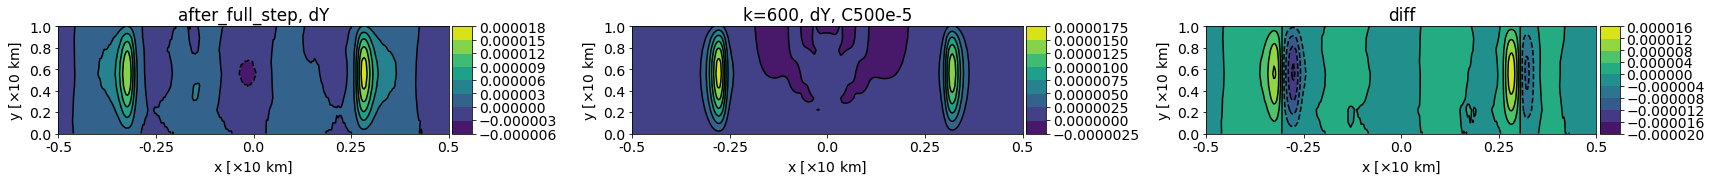

In [1629]:
dbg_data = np.zeros([ncx,ncy,ntime])

directory = ['dY','rhoY','p2_nodes','Y','rho','u','v','w','buoy','rhs_nodes']
filename = ['dY','rhoY','p2_n','Y','rho','u','v','w','buoy', 'rhs_nodes']

directory = ['dY']
filename = ['dY']

k = 600
k_py = 1

k_py = k

shft = 1 if k < 4 else 2
attribute = 'rhoY'
times = np.arange(0,1)
times = np.arange(0,k)
# tag = tags[k+shft]
tag = tags[9]
print(tag)
attribute = 'rho'
_, rho = get_ens(tc, times, sfx1, diff, attribute,tag=tag)
rho = rho[2,...]
attribute = 'rhou'
attribute = 'p2_nodes'

for qq, qty in enumerate(directory):
    if qty == 'dY' or qty == 'Y':
        attribute = 'rhoY'
        _, a2 = get_ens(tc, times, sfx1, diff, attribute,tag=tag)
        a2 = a2[2,...]
        aa = a2 / rho
        if qty == 'dY':
            aa -= S0

    if qty == 'rhoY':
        attribute = 'rhoY'
        _, a2 = get_ens(tc, times, sfx1, diff, attribute,tag=tag)
        aa = a2[2,...]

    if qty == 'p2_nodes':
        attribute = 'p2_nodes'
        _, a2 = get_ens(tc, times, sfx1, diff, attribute,tag=tag)
        aa = a2[2,...]   

    if qty == 'rho':
        aa = rho

    if qty == 'u' or qty == 'v' or qty == 'w':
        attribute = 'rho' + qty
        _, a2 = get_ens(tc, times, sfx1, diff, attribute,tag=tag)
        a2 = a2[2,...]
        aa = a2/rho
        
    if qty == 'buoy':
        attribute = 'rhoX'
        _, a2 = get_ens(tc, times, sfx1, diff, attribute,tag=tag)
        a2 = a2[3,...]
        aa = rho / a2
        aa = a2 / rho
        
    if qty == 'rhs_nodes' and (k == 3 or k == 7):
        attribute = 'rhs'
        _, a2 = get_ens(tc, times, sfx1, diff, attribute,tag=tag, load_ic = False)
        aa = a2[3,...]
        k_py = 0
            
    aa = aa[i2]

    aa = np.swapaxes(aa,0,1)
    ll = [aa[...,k_py].T, '%s, %s' %(tag, qty)]

    if (qty == 'rhs_nodes' and k == 3):
        k = 0
    elif (qty == 'rhs_nodes' and k == 7):
        k = 1
    
    conv = converter.convert(folderstring,'','%.3d' %k,'')
    conv.convert_files([qty],[filename[qq]],debug=True)
    SD = conv.get_converted_files(qty,filename[qq])
    arr = getattr(SD, qty)[...,2]
    print(arr.shape)
    arr = arr[2:-2,2:-2]

    ll_rklm = [arr.T, 'k=%i, %s, %s' %(k, qty, casestr)]
    
    diff_ll = ll[0]-ll_rklm[0]
    diff_ll = [diff_ll, 'diff']
    
    print(ll[0].max(), ll[0].min(), ll[0].max() - ll[0].min())
    print(ll_rklm[0].max(), ll_rklm[0].min(), ll_rklm[0].max() - ll_rklm[0].min())
        
    pl_lst = [ll, ll_rklm, diff_ll]

    pl = pt.plotter(pl_lst,ncols=3,figsize=(24,3),sharey=False)
    x_axs = [-0.5,-0.25,0.0,0.25,0.5]
    y_axs = [-0.5,-0.25,0.0,0.25,0.5]
    y_axs = np.array([0.0,2.0,4.0,6.0,8.0,10.0]) / 10.0
    x_loc = np.linspace(0,Nx-1,5)
    y_loc = np.linspace(0,Ny-1,6)
    x_label = r'x [$\times 10$ km]'
    y_label = r'y [$\times 10$ km]'

    pl.set_axes(y_locs=y_loc,y_axs=y_axs)
    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
    _ = pl.plot(method='contour', lvls=None)